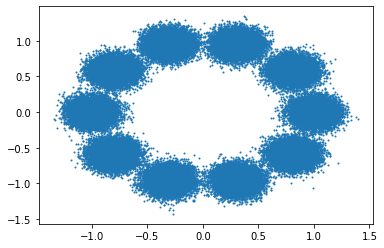

In [17]:
import numpy as np
import torch.nn as nn
import torch.nn.init
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional


n_category = 10


class CustomDataSet(torch.utils.data.Dataset):

    def __init__(self, n_group, n_data):

        self.n_group = n_group
        self.n_data = n_data
        _data = np.random.randn(self.n_data, 2)
        _label = np.ndarray(self.n_data, dtype=np.int)
        _mu = []
        _sig = 0.1
        for k in range(n_group):
            _mu.append([np.cos(2.0 * np.pi * k / n_group), np.sin(2.0 * np.pi * k / n_group)])
        for i in range(n_data):
            _data[i][0] = _sig * _data[i][0] + _mu[i % n_group][0]
            _data[i][1] = _sig * _data[i][1] + _mu[i % n_group][1]
            _label[i] = i % n_group

        self.data = torch.as_tensor(_data, dtype=torch.float32)
        self.label = torch.as_tensor(_label, dtype=torch.int64)

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=2 + n_category, out_features=64, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=64, out_features=64, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=64, out_features=32, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=32, out_features=1, bias=True),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.layer(x)


class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=2 + n_category, out_features=64, bias=True),
            torch.nn.LeakyReLU(negative_slope=0.1),
            torch.nn.Linear(in_features=64, out_features=64, bias=True),
            torch.nn.LeakyReLU(negative_slope=0.1),
            torch.nn.Linear(in_features=64, out_features=32, bias=True),
            torch.nn.LeakyReLU(negative_slope=0.1),
            torch.nn.Linear(in_features=32, out_features=2, bias=True),
        )

    def forward(self, x):
        return self.layer(x)


data_size = 120000
dataset = CustomDataSet(n_group=n_category, n_data=data_size)

data_points = dataset.data.numpy()
plt.scatter(data_points[:, 0], data_points[:, 1], s=1)
plt.show()

In [18]:
batch_size = 32
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

discriminator = Discriminator()
generator = Generator()
discriminator_optimizer = torch.optim.SGD(discriminator.parameters(), lr=0.01)
generator_optimizer = torch.optim.SGD(generator.parameters(), lr=0.01)

num_epochs = 200
for epoch in range(num_epochs):
    avg_p_real = 0.0
    avg_p_fake = 0.0
    for mini_batch_index, mini_batch in enumerate(loader):
        data, label = mini_batch
        label = torch.nn.functional.one_hot(label, num_classes=n_category).float()
        discriminator_optimizer.zero_grad()
        p_real = discriminator(torch.cat([data, label], dim=1)).mean()
        generator_output = generator(torch.cat([torch.randn(batch_size, 2), label], dim=1))
        p_fake = discriminator(torch.cat([generator_output, label], dim=1)).mean()
        discriminator_loss = (-(torch.log(p_real) + torch.log(1.0 - p_fake)))
        discriminator_loss.backward()
        discriminator_optimizer.step()

        generator_optimizer.zero_grad()
        generator_output = generator(torch.cat([torch.randn(batch_size, 2), label], dim=1))
        generator_loss = (-torch.log(discriminator(torch.cat([generator_output, label], dim=1)))).mean()
        generator_loss.backward()
        generator_optimizer.step()

        avg_p_fake += p_fake.item()
        avg_p_real += p_real.item()
    avg_p_real = avg_p_real/len(loader)
    avg_p_fake = avg_p_fake/len(loader)
    print(avg_p_real, avg_p_fake)

0.5706833689272404 0.4165680700202783
0.4997906703869502 0.4999041567405065
0.4998998484214147 0.4999252328554789
0.4998790836731593 0.5000321569601694
0.4999652258872986 0.5000591376622517
0.4998875605106354 0.4999986571709315
0.49992335577805835 0.5000387190580368
0.4999077994028727 0.5000330495993296
0.4999540650606155 0.5000419127384822
0.4999731685400009 0.5000609378099442
0.4999372473080953 0.5000381074349085
0.49988962148030597 0.4999742031812668
0.4999516365130742 0.5000220881621043
0.49994617757797244 0.49998904984792075
0.4999342970053355 0.500007621939977
0.4999737623532613 0.5000181622028351
0.4999590307235718 0.5000233679850896
0.4999711764494578 0.5000131448745727
0.49996767745018006 0.5000319811423619
0.499887882010142 0.49995397386550905
0.4999652158419291 0.5000389069159825
0.4999590234835943 0.500000603612264
0.4999416825532913 0.5000724670330683
0.49997823506196337 0.5000072252353033
0.4999276503801346 0.4999815387248993
0.4999057022730509 0.5000092228809992
0.499964

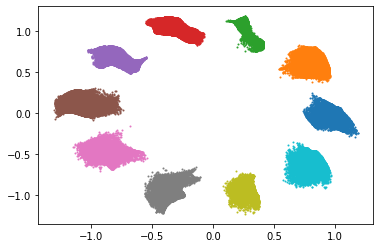

In [23]:
labels = torch.as_tensor(np.zeros(10000 * n_category, dtype=np.int), dtype=torch.int64)
for k in range(n_category):
    for i in range(10000):
        labels[k*10000 + i] = k

labels = torch.nn.functional.one_hot(labels, num_classes=n_category).float()


generator_output = generator(torch.cat([torch.randn(10000 * n_category, 2), labels], dim=1)).data.numpy()
for k in range(n_category):
    plt.scatter(generator_output[k*10000:(k+1)*10000, 0], generator_output[k*10000:(k+1)*10000, 1], s=1)
plt.show()